# Visualising Overture data and breaking it down into sectors

In [1]:
import numpy as np
import json
# import shapely
from scalenav.plotting import cmap
import scalenav.oop as snoo
import matplotlib.pyplot as plt

import ibis as ib
from ibis import _
import ibis.selectors as s

ib.options.interactive = True
ib.options.graphviz_repr = True

import pydeck as pdk


## Params

In [2]:
from parameters import *
bboxs = json.load(open("data/bboxs.json","r"))

In [3]:
# the spatial extension
# https://duckdb.org/docs/extensions/spatial/functions

# the h3 extension in duckdb
# https://github.com/isaacbrodsky/h3-duckdb?tab=readme-ov-file

conn = snoo.sn_connect("../" + overture_db_filename,interactive=True, memory_limit="100GB",access_mode="READ_ONLY",threads = 8)

connecting to existing database.


## Guide on working with Overture
Smaller files are downloaded here

https://docs.overturemaps.org/guides/

https://github.com/OvertureMaps/data?tab=readme-ov-file 

## Selecting an area of interest

In [4]:
bbox_name = 'global'
bbox = bboxs[bbox_name]

In [5]:
# Set the viewport location
view_state = pdk.ViewState(latitude=np.mean(bbox[1::2]), longitude=np.mean(bbox[0::2]), zoom=3, bearing=0, pitch=30)

## Local places and landuse file

In [6]:
conn.list_tables()

['boundaries',
 'dose_wdi',
 'overture_h3_geom',
 'overture_landuse',
 'overture_pois',
 'places',
 'places_types']

In [7]:
# overture_data = conn.read_parquet("../" + overture_places_landuses_filename)
overture_data = conn.table("overture_pois")


In [8]:
print(overture_data.columns)

['id', 'sec_cat', 'x', 'y', 'sec_cat_right', 'section', 'isic_embed', 'isic_descr', 'dose', 'match_score', 'h3_id']


In [9]:
overture_sections = overture_data.section.value_counts().execute()

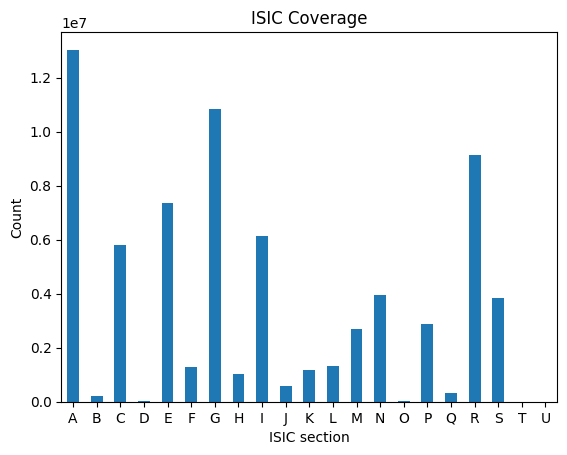

In [10]:
overture_sections.plot.bar(x="section",y="section_count",title="ISIC Coverage",xlabel="ISIC section",ylabel="Count",legend=False,rot=0)
plt.savefig("isic_count_overture.png")
plt.show()

In [11]:
overture_data_top_cat = overture_data.sec_cat.value_counts().head(10).execute().sec_cat.to_list()

In [12]:
overture_data_top_cat

['retail',
 'protected',
 'zoo',
 'brownfield',
 'vineyard',
 'water_park',
 'institutional',
 'static_caravan',
 'private_investigation',
 'home_cleaning']

In [13]:
overture_data.count()

┌──────────┐
│ 71683808 │
└──────────┘

In [14]:
overture_data.distinct(on="h3_id").count()

┌──────────┐
│ 50066465 │
└──────────┘

## Economic classification of Overture places and landuses

In [15]:
overture_data.head().execute()

,id,sec_cat,x,y,sec_cat_right,section,isic_embed,isic_descr,dose,match_score,h3_id
0,08b8f2cb53446fff0002bc3938fb6497,grass,-79.193985,-0.293653,grass,E,37,Sewerage,manufacturing,0.278747,8b8f2cb53446fff
1,08b8f2cb53444fff0002b8f731b56a62,grass,-79.193428,-0.293267,grass,E,37,Sewerage,manufacturing,0.278747,8b8f2cb53444fff
2,08b8f2cb53465fff0002b43f6da36210,grass,-79.192528,-0.292631,grass,E,37,Sewerage,manufacturing,0.278747,8b8f2cb53465fff
3,08b8f2cb5354cfff0002b97be7c979b9,school,-79.192230,-0.291138,school,P,85,Education,services,0.378567,8b8f2cb5354cfff
4,08b8f2cb5224afff0002bfeb689f43f5,school,-79.198265,-0.287720,school,P,85,Education,services,0.378567,8b8f2cb5224afff


In [16]:
overture_data.filter(~_.dose.isnull()).select("sec_cat").distinct()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ sec_cat                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ string                       │
├──────────────────────────────┤
│ works                        │
│ driving_range                │
│ green                        │
│ protected_landscape_seascape │
│ danger_area                  │
│ obstacle_course              │
│ barracks                     │
│ highway                      │
│ peat_cutting                 │
│ tanning_salon                │
│ …                            │
└──────────────────────────────┘

In [17]:
overture_data = overture_data.drop_null(subset=["dose"],how="any")

In [18]:
overture_data.count()

┌──────────┐
│ 71683808 │
└──────────┘

In [19]:
overture_data = overture_data.filter(_.match_score > .4)

In [20]:
overture_data.count()

┌──────────┐
│ 42580904 │
└──────────┘

### ISIC categories mapped

In [21]:
places_isic = overture_data.select(["id","dose","sec_cat","x","y"])

In [22]:
places_isic.head()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ id                               ┃ dose          ┃ sec_cat      ┃ x          ┃ y         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ string                           │ string        │ string       │ float32    │ float32   │
├──────────────────────────────────┼───────────────┼──────────────┼────────────┼───────────┤
│ 08b8f2cb5a88cfff0002b59c6f1f847f │ services      │ hospital     │ -79.169258 │ -0.322253 │
│ 08b8f2cb53906fff0002bc60315fc2a4 │ services      │ hospital     │ -79.183823 │ -0.279552 │
│ 08b8f2cb544a9fff0002ba029aa3e3f7 │ manufacturing │ construction │ -79.192764 │ -0.246977 │
│ 08b8f2cb55520fff0002ba12c2d8f45a │ services      │ hospital     │ -79.171303 │ -0.254928 │
│ 08b8f2cb55cabfff0002b2bef7ab4325 │ services      │ retail       │ -79.170494 │ -0.253329 │
└──────────────────────────────────┴───────────────┴──────────────┴────────────┴───────────┘

## Plotting DOSE classifications

In [23]:
places_isic = places_isic.drop_null(subset="dose")

In [24]:
places_isic.head()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ id                               ┃ dose          ┃ sec_cat      ┃ x          ┃ y         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ string                           │ string        │ string       │ float32    │ float32   │
├──────────────────────────────────┼───────────────┼──────────────┼────────────┼───────────┤
│ 08b8f2cb5a88cfff0002b59c6f1f847f │ services      │ hospital     │ -79.169258 │ -0.322253 │
│ 08b8f2cb53906fff0002bc60315fc2a4 │ services      │ hospital     │ -79.183823 │ -0.279552 │
│ 08b8f2cb544a9fff0002ba029aa3e3f7 │ manufacturing │ construction │ -79.192764 │ -0.246977 │
│ 08b8f2cb55520fff0002ba12c2d8f45a │ services      │ hospital     │ -79.171303 │ -0.254928 │
│ 08b8f2cb55cabfff0002b2bef7ab4325 │ services      │ retail       │ -79.170494 │ -0.253329 │
└──────────────────────────────────┴───────────────┴──────────────┴────────────┴───────────┘

In [25]:
places_isic.dose.value_counts()

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ dose          ┃ dose_count ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ string        │ int64      │
├───────────────┼────────────┤
│ services      │   26700300 │
│ manufacturing │    5263304 │
│ agriculture   │   10617300 │
└───────────────┴────────────┘

In [26]:
places_isic[places_isic.dose=="manufacturing"]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ id                               ┃ dose          ┃ sec_cat      ┃ x          ┃ y         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ string                           │ string        │ string       │ float32    │ float32   │
├──────────────────────────────────┼───────────────┼──────────────┼────────────┼───────────┤
│ 08b8f2cb544a9fff0002ba029aa3e3f7 │ manufacturing │ construction │ -79.192764 │ -0.246977 │
│ 08b8f2cb52b9bfff0002b19312ea6ab3 │ manufacturing │ industrial   │ -79.200867 │ -0.276154 │
│ 08b8f2cb52b5afff0002b7bb7632958a │ manufacturing │ industrial   │ -79.195312 │ -0.276687 │
│ 08b8f2cb50480fff0002be088029736e │ manufacturing │ industrial   │ -79.196762 │ -0.270203 │
│ 08b8f2cb4248afff0002b37caa41b6a4 │ manufacturing │ industrial   │ -79.155678 │ -0.275980 │
│ 08b8f2cb51959fff0002be0e815169f9 │ manufacturing │ industrial   │ -79.158974 │ -0.274025 │
│ 08b8f2cb41885fff0002b7086fd8655f │ manufacturing │ industrial   │ -79.103302 │ -0.270755 │
│ 08b8f2cb560c3fff0002b9f363557eee │ manufacturing │ industrial   │ -79.204689 │ -0.257691 │
│ 08b8f2cb5616afff0002b3bddd22ee6b │ manufacturing │ industrial   │ -79.200165 │ -0.253032 │
│ 08b8f2cb544dcfff0002b193c85d2fb5 │ manufacturing │ industrial   │ -79.192474 │ -0.249423 │
│ …                                │ …             │ …            │          … │         … │
└──────────────────────────────────┴───────────────┴──────────────┴────────────┴───────────┘

## Adding econ data

In [27]:
conn.raw_sql(
"""CREATE OR REPLACE TABLE dose_wdi as (
    SELECT * FROM '../datasets/local_data/dose-wdi/0_3/dose_wdi_geo.parquet');
""")

In [28]:
dose_wdi = conn.table("dose_wdi")

In [29]:
dose_wdi = (
    dose_wdi.select("gid_0","country","gid_1","grp_usd_2015","services_usd_2015","manufacturing_usd_2015","agriculture_usd_2015","geometry","x","y")
    .filter(_.x>bbox[0],
            _.x<bbox[2],
            _.y>bbox[1],
            _.y<bbox[3])
)

In [30]:
print(dose_wdi.count())
dose_wdi.head()

┌──────┐
│ 1649 │
└──────┘


┏━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ gid_0  ┃ country ┃ gid_1   ┃ grp_usd_2015 ┃ services_usd_2015 ┃ manufacturing_usd_2015 ┃ agriculture_usd_2015 ┃ geometry                                                                         ┃ x         ┃ y         ┃
┡━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ string │ string  │ string  │ float64      │ float64           │ float64                │ float64              │ geospatial:geometry                                                              │ float64   │ float64   │
├────────┼─────────┼─────────┼──────────────┼───────────────────┼────────────────────────┼──────────────────────┼──────────────────────────────────────────────────────────────────────────────────┼───────────┼───────────┤
│ ALB    │ Albania │ ALB.1_1 │ 4.341915e+08 │      2.009631e+08 │           9.449606e+07 │         8.588401e+07 │ <POLYGON ((20.379 40.435, 20.377 40.436, 20.373 40.437, 20.369 40.438, 20.36...> │ 20.090775 │ 40.628500 │
│ ALB    │ Albania │ ALB.2_1 │ 3.719427e+08 │      1.721516e+08 │           8.094841e+07 │         7.357106e+07 │ <POLYGON ((20.422 41.282, 20.423 41.282, 20.422 41.283, 20.421 41.284, 20.42...> │ 20.249534 │ 41.589105 │
│ ALB    │ Albania │ ALB.3_1 │ 1.113524e+09 │      5.153885e+08 │           2.423439e+08 │         2.202575e+08 │ <POLYGON ((19.638 41.341, 19.636 41.337, 19.637 41.335, 19.64 41.33, 19.642 ...> │ 19.630373 │ 41.447333 │
│ ALB    │ Albania │ ALB.4_1 │ 7.954835e+08 │      3.681851e+08 │           1.731265e+08 │         1.573483e+08 │ <POLYGON ((20.437 40.849, 20.437 40.848, 20.44 40.847, 20.441 40.841, 20.446...> │ 20.186454 │ 41.040028 │
│ ALB    │ Albania │ ALB.5_1 │ 1.345159e+09 │      6.225993e+08 │           2.927561e+08 │         2.660753e+08 │ <POLYGON ((19.744 40.452, 19.745 40.457, 19.743 40.459, 19.741 40.462, 19.73...> │ 19.620528 │ 40.774633 │
└────────┴─────────┴─────────┴──────────────┴───────────────────┴────────────────────────┴──────────────────────┴──────────────────────────────────────────────────────────────────────────────────┴───────────┴───────────┘

## Spatial join v2

This approach first groups features spatially on H3, then pivots the values to get a table with a row for each spatial index and the densities of features in each column. 

In [31]:
overture_data.head()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ id                               ┃ sec_cat      ┃ x          ┃ y         ┃ sec_cat_right ┃ section ┃ isic_embed ┃ isic_descr                                             ┃ dose          ┃ match_score ┃ h3_id           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ string                           │ string       │ float32    │ float32   │ string        │ string  │ string     │ string                                                 │ string        │ float64     │ string          │
├──────────────────────────────────┼──────────────┼────────────┼───────────┼───────────────┼─────────┼────────────┼────────────────────────────────────────────────────────┼───────────────┼─────────────┼─────────────────┤
│ 08b8f2cb5a88cfff0002b59c6f1f847f │ hospital     │ -79.169258 │ -0.322253 │ hospital      │ Q       │ 86         │ Human health activities                                │ services      │    0.422409 │ 8b8f2cb5a88cfff │
│ 08b8f2cb53906fff0002bc60315fc2a4 │ hospital     │ -79.183823 │ -0.279552 │ hospital      │ Q       │ 86         │ Human health activities                                │ services      │    0.422409 │ 8b8f2cb53906fff │
│ 08b8f2cb544a9fff0002ba029aa3e3f7 │ construction │ -79.192764 │ -0.246977 │ construction  │ F       │ 41         │ Construction of buildings                              │ manufacturing │    0.713332 │ 8b8f2cb544a9fff │
│ 08b8f2cb55520fff0002ba12c2d8f45a │ hospital     │ -79.171303 │ -0.254928 │ hospital      │ Q       │ 86         │ Human health activities                                │ services      │    0.422409 │ 8b8f2cb55520fff │
│ 08b8f2cb55cabfff0002b2bef7ab4325 │ retail       │ -79.170494 │ -0.253329 │ retail        │ G       │ 47         │ Retail trade, except of motor vehicles and motorcycles │ services      │    0.493995 │ 8b8f2cb55cabfff │
└──────────────────────────────────┴──────────────┴────────────┴───────────┴───────────────┴─────────┴────────────┴────────────────────────────────────────────────────────┴───────────────┴─────────────┴─────────────────┘

In [41]:
overture_data = snoo.sn_project(overture_data,res=3)

Existing h3_id column will be overwritten
Assuming coordinates columns ('x','y')


In [42]:
overture_data.h3_id.nunique()

┌───────┐
│ 21087 │
└───────┘

In [43]:
overture_data.count()

┌──────────┐
│ 42580904 │
└──────────┘

## Transorming the data

In [44]:
overture_h3_dens = (
    overture_data
    .select("id","h3_id","dose")
    .pivot_wider(
        id_cols="h3_id",
        names_from="dose",
        values_from="id",
        values_agg="count",
        values_fill=0,
    )
)

In [47]:
overture_h3_dens.h3_id.nunique()

┌───────┐
│ 21087 │
└───────┘

In [53]:
overture_h3_dens.count()

┌───────┐
│ 21087 │
└───────┘

In [ ]:
cols = overture_h3_dens.select(s.of_type(int)).columns

['agriculture', 'manufacturing', 'services']

In [72]:
overture_h3_geom = (
    snoo.sn_add_centr(overture_h3_dens)
    .rename({x + "_var" : x for x in cols})
    )
overture_h3_geom.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ h3_id           ┃ agriculture_var ┃ manufacturing_var ┃ services_var ┃ geom                     ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ string          │ int64           │ int64             │ int64        │ geospatial:geometry      │
├─────────────────┼─────────────────┼───────────────────┼──────────────┼──────────────────────────┤
│ 83195dfffffffff │           22848 │             30198 │       155877 │ <POINT (-0.943 51.805)>  │
│ 836948fffffffff │             537 │                10 │          254 │ <POINT (122.512 14.799)> │
│ 834103fffffffff │              50 │               635 │         4319 │ <POINT (113.879 21.754)> │
│ 83316cfffffffff │              56 │               638 │         1988 │ <POINT (132.122 43.155)> │
│ 832ecdfffffffff │              24 │                13 │           13 │ <POINT (133.274 43.546)> │
└─────────────────┴─────────────────┴───────────────────┴──────────────┴──────────────────────────┘

In [ ]:
overture_h3_geom = conn.create_table(obj=overture_h3_geom,name="overture_h3_geom",overwrite=True)

In [76]:
conn.list_tables()

['boundaries',
 'dose_wdi',
 'ibis_cache_sotfmq7s5fh67mwnjwguqmxkhe',
 'overture_h3_geom',
 'overture_landuse',
 'overture_pois',
 'places',
 'places_types']

In [77]:
dose_wdi.head()

┏━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ gid_0  ┃ country ┃ gid_1   ┃ grp_usd_2015 ┃ services_usd_2015 ┃ manufacturing_usd_2015 ┃ agriculture_usd_2015 ┃ geometry                                                                         ┃ x         ┃ y         ┃
┡━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ string │ string  │ string  │ float64      │ float64           │ float64                │ float64              │ geospatial:geometry                                                              │ float64   │ float64   │
├────────┼─────────┼─────────┼──────────────┼───────────────────┼────────────────────────┼──────────────────────┼──────────────────────────────────────────────────────────────────────────────────┼───────────┼───────────┤
│ ALB    │ Albania │ ALB.1_1 │ 4.341915e+08 │      2.009631e+08 │           9.449606e+07 │         8.588401e+07 │ <POLYGON ((20.379 40.435, 20.377 40.436, 20.373 40.437, 20.369 40.438, 20.36...> │ 20.090775 │ 40.628500 │
│ ALB    │ Albania │ ALB.2_1 │ 3.719427e+08 │      1.721516e+08 │           8.094841e+07 │         7.357106e+07 │ <POLYGON ((20.422 41.282, 20.423 41.282, 20.422 41.283, 20.421 41.284, 20.42...> │ 20.249534 │ 41.589105 │
│ ALB    │ Albania │ ALB.3_1 │ 1.113524e+09 │      5.153885e+08 │           2.423439e+08 │         2.202575e+08 │ <POLYGON ((19.638 41.341, 19.636 41.337, 19.637 41.335, 19.64 41.33, 19.642 ...> │ 19.630373 │ 41.447333 │
│ ALB    │ Albania │ ALB.4_1 │ 7.954835e+08 │      3.681851e+08 │           1.731265e+08 │         1.573483e+08 │ <POLYGON ((20.437 40.849, 20.437 40.848, 20.44 40.847, 20.441 40.841, 20.446...> │ 20.186454 │ 41.040028 │
│ ALB    │ Albania │ ALB.5_1 │ 1.345159e+09 │      6.225993e+08 │           2.927561e+08 │         2.660753e+08 │ <POLYGON ((19.744 40.452, 19.745 40.457, 19.743 40.459, 19.741 40.462, 19.73...> │ 19.620528 │ 40.774633 │
└────────┴─────────┴─────────┴──────────────┴───────────────────┴────────────────────────┴──────────────────────┴──────────────────────────────────────────────────────────────────────────────────┴───────────┴───────────┘

In [ ]:
# the next steps could be done with this function in the future : 
# h3_gid_dens = snoo.sn_rescale(input=overture_h3_geom,
#                 weight=dose_wdi,
#                 weight_var="agriculture_usd_2015",
#                 weight_id="gid_1",).cache()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
h3_gid_dens = overture_h3_geom.alias("t_geom").sql("""
SELECT t_geom.* EXCLUDE geom,
        dose_wdi.gid_1,
        dose_wdi.gid_0,
        dose_wdi.grp_usd_2015,
        dose_wdi.services_usd_2015,
        dose_wdi.manufacturing_usd_2015,
        dose_wdi.agriculture_usd_2015
    FROM t_geom 
    LEFT OUTER JOIN dose_wdi 
    ON ST_CONTAINS(dose_wdi.geometry,t_geom.geom::GEOMETRY);
""").cache()

In [81]:
print(h3_gid_dens.count())
h3_gid_dens.head()

┌────────┐
│ 285622 │
└────────┘


┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ h3_id           ┃ manufacturing ┃ agriculture ┃ services ┃ gid_1   ┃ agriculture_usd_2015 ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ string          │ int64         │ int64       │ int64    │ string  │ float64              │
├─────────────────┼───────────────┼─────────────┼──────────┼─────────┼──────────────────────┤
│ 851e105bfffffff │           148 │         279 │      346 │ AUT.2_1 │         3.406501e+08 │
│ 851e0673fffffff │           142 │          34 │      101 │ AUT.3_1 │         1.264955e+09 │
│ 851e3327fffffff │            98 │         189 │       85 │ AUT.3_1 │         1.264955e+09 │
│ 851e06cbfffffff │            79 │         425 │      145 │ AUT.3_1 │         1.264955e+09 │
│ 851e158ffffffff │            48 │         103 │      106 │ AUT.3_1 │         1.264955e+09 │
└─────────────────┴───────────────┴─────────────┴──────────┴─────────┴──────────────────────┘

In [82]:
conn.list_tables()

['boundaries',
 'dose_wdi',
 'ibis_cache_6j2ssrlugfdm5k3f5ob4vup76q',
 'ibis_cache_sotfmq7s5fh67mwnjwguqmxkhe',
 'overture_h3_geom',
 'overture_landuse',
 'overture_pois',
 'places',
 'places_types']

In [55]:
#  similar to previous cell but using windows: 
grid_dens = (
    h3_gid_dens
    .mutate(
        services_dens=(_.services/_.services.sum().over(group_by=_.gid_1)),
        manufacturing_dens=(_.manufacturing/_.manufacturing.sum().over(group_by=_.gid_1)),
        )
    .mutate(
        services_h3_gdp = (_.services_dens*_.services_usd_2015).round(),
        manufacturing_h3_gdp = (_.manufacturing_dens*_.manufacturing_usd_2015).round(),
            )
    .fill_null({
        "services_h3_gdp" : 0,
        "manufacturing_h3_gdp" : 0,
        })
)

In [83]:
grid_dens.head()

┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ h3_id           ┃ manufacturing ┃ agriculture ┃ services ┃ gid_1   ┃ gid_0  ┃ grp_usd_2015 ┃ services_usd_2015 ┃ manufacturing_usd_2015 ┃ agriculture_usd_2015 ┃ services_dens ┃ manufacturing_dens ┃ services_h3_gdp ┃ manufacturing_h3_gdp ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ string          │ int64         │ int64       │ int64    │ string  │ string │ float64      │ float64           │ float64                │ float64              │ float64       │ float64            │ int64           │ int64                │
├─────────────────┼───────────────┼─────────────┼──────────┼─────────┼────────┼──────────────┼───────────────────┼────────────────────────┼──────────────────────┼───────────────┼────────────────────┼─────────────────┼──────────────────────┤
│ 851fa443fffffff │          1705 │        1321 │    13363 │ BEL.1_1 │ BEL    │ 8.757383e+10 │      7.159683e+10 │           6.837799e+09 │         1.830840e+07 │      0.689703 │            0.70953 │     49380563950 │           4851621874 │
│ 851fa44ffffffff │           698 │         309 │     6012 │ BEL.1_1 │ BEL    │ 8.757383e+10 │      7.159683e+10 │           6.837799e+09 │         1.830840e+07 │      0.310297 │            0.29047 │     22216265095 │           1986177166 │
│ 8558a3dbfffffff │             5 │           9 │        0 │ BEN     │ BEN    │ 1.138816e+10 │      5.607633e+09 │           1.865961e+09 │         3.005573e+09 │      0.000000 │            0.00780 │               0 │             14555078 │
│ 8558b137fffffff │             0 │           5 │        0 │ BEN     │ BEN    │ 1.138816e+10 │      5.607633e+09 │           1.865961e+09 │         3.005573e+09 │      0.000000 │            0.00000 │               0 │                    0 │
│ 8558167bfffffff │             0 │          31 │        9 │ BEN     │ BEN    │ 1.138816e+10 │      5.607633e+09 │           1.865961e+09 │         3.005573e+09 │      0.002160 │            0.00000 │        12114425 │                    0 │
└─────────────────┴───────────────┴─────────────┴──────────┴─────────┴────────┴──────────────┴───────────────────┴────────────────────────┴──────────────────────┴───────────────┴────────────────────┴─────────────────┴──────────────────────┘

In [57]:
# ib.to_sql(grid_dens)

In [84]:
h3_grid=(
    grid_dens
    .select(~s.matches("(_usd_)|(_dens)|(agriculture)")
            )
).execute()

In [85]:
print(h3_grid.shape)
h3_grid.head()

(285622, 7)


,h3_id,manufacturing,services,gid_1,gid_0,services_h3_gdp,manufacturing_h3_gdp
0,851fa443fffffff,1705,13363,BEL.1_1,BEL,49380563950,4.851622e+09
1,851fa44ffffffff,698,6012,BEL.1_1,BEL,22216265095,1.986177e+09
2,8558a3dbfffffff,5,0,BEN,BEN,0,1.455508e+07
3,8558b137fffffff,0,0,BEN,BEN,0,0.000000e+00
4,8558167bfffffff,0,9,BEN,BEN,12114425,0.000000e+00


In [86]:
h3_grid["services_cols"] = cmap(input=h3_grid.services_h3_gdp,log=True,palette=gdp_pal)
h3_grid["manufacturing_cols"] = cmap(input=h3_grid.manufacturing_h3_gdp,log=True,palette=gdp_pal)

Max input : 26.32, palette colors : 256
Max input : 24.63, palette colors : 256


### Formatted strings

In [87]:
h3_grid["serv_format"] = h3_grid.services_h3_gdp.apply(lambda x: f"{x:,}")
h3_grid["manuf_format"] = h3_grid.manufacturing_h3_gdp.apply(lambda x: f"{x:,}")


In [88]:
# h3_grid

## Map downscaled

In [90]:
# Define a layer to display on a map
# layer = pdk.Layer(
#     "H3HexagonLayer",
#     h3_grid[h3_grid.services_h3_gdp!=0],
#     pickable=True,
#     stroked=True,
#     filled=True,
#     opacity = .6,
#     extruded=False,
#     get_hexagon="h3_id",
#     get_fill_color= "services_cols",
#     get_line_color=[255, 255, 255, 0],
#     line_width_min_pixels=1,
#     line_width_max_pixels=2,
# )

# # Render
# r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"html": "<h3> Estimated GDP </h3> <p> Services sector : {serv_format} </p> <p> Manufacturing sector : {manuf_format} </p>"})
# r.to_html(f"../deck_maps/{bbox_name}_h3_services_hexagon_layer.html", iframe_height=700)

In [ ]:
# Define a layer to display on a map
# layer = pdk.Layer(
#     "H3HexagonLayer",
#     h3_grid[h3_grid.manufacturing_h3_gdp!=0],
#     pickable=True,
#     stroked=True,
#     filled=True,
#     opacity = .6,
#     extruded=False,
#     get_hexagon="h3_id",
#     get_fill_color= "manufacturing_cols",
#     get_line_color=[255, 255, 255, 0],
#     line_width_min_pixels=1,
#     line_width_max_pixels=2,
# )

# # Render
# r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"html": "<h3> Estimated GDP </h3> <p> Services sector : {serv_format} </p> <p> Manufacturing sector : {manuf_format} </p>"})
# r.to_html(f"../deck_maps/{bbox_name}_h3_manufacturing_hexagon_layer.html", iframe_height=700)